In [12]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date

import file

In [13]:
# Define the ticker symbol
tickerSymbol = 'QQQ'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())

In [14]:
CL = history['Low'].shift(-1) / history['Close'] - 1
print(f'{tickerSymbol} Close to next Low median {CL.median():.2%}')

QQQ Close to next Low median -1.54%


In [15]:
max_weeks = 50

In [16]:
gap = (5/430)*100
option_prices = {
    # 1: [435/2.87, 435/4.33],
    2: [435/4.49, 435/6.62],
    3: [435/6.03, 435/8.59],
    4: [415/10.37, 435/7.64, 435/9.57],
    5: [415/11.86, 435/8.59, 435/10.84],
    6: [415/12.92, 435/9.75, 435/12.16],
    7: [435/13.07],
    8: [435/11.85, 435/13.88],
    9: [415/16.35, 435/12.62],
    11: [435/16.45],
    12: [435/15.15],
    13: [415/19.55],
    15: [435/20.16],
    16: [435/18.73],
    17: [415/23.06],
    20: [435/24.33],
    21: [435/22.86],
    22: [415/27.19],
    24: [435/27.06],
    25: [435/25.63],
    26: [415/29.83],
    29: [435/29.18],
    30: [415/33.21],
    34: [435/32.81],
    35: [415/36.78],
    36: [435/33.23],
    39: [415/36.14]
}
print('option leverages:')
for w in option_prices:
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
option_leverage |= {
 1: 92.0844327176781,
 2: 60.71839464882943,
 3: 47.354138398914515,
 4: 40.0,
 5: 35.7926221335992,
 6: 31.53118919836513,
 7: 28.45482587416874,
 8: 25.657298277425205,
 9: 24.981949458483754,
 10: 23.388429752066116,
 11: 22.802813653136532,
 12: 20.210280373831775,
 13: 20.966962090351938,
 14: 19.204628599977436,
 15: 18.361581920903955,
 16: 18.489638521389,
 17: 16.84843687457022,
 18: 16.657967988865693,
 19: 16.006021073758152,
 20: 15.980370425102212,
 21: 15.018484288354898,
 22: 14.927012321632724,
 23: 14.291474654377879,
 24: 13.770913770913772,
 25: 13.528843202327359,
 26: 13.204442616207324}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 2w 96.9 65.7
	 3w 72.1 50.6
	 4w 40.0 56.9 45.5
	 5w 35.0 50.6 40.1
	 6w 32.1 44.6 35.8
	 7w 33.3
	 8w 36.7 31.3
	 9w 25.4 34.5
	11w 26.4
	12w 28.7
	13w 21.2
	15w 21.6
	16w 23.2
	17w 18.0
	20w 17.9
	21w 19.0
	22w 15.3
	24w 16.1
	25w 17.0
	26w 13.9
	29w 14.9
	30w 12.5
	34w 13.3
	35w 11.3
	36w 13.1
	39w 11.5
mean option leverage, break even:
	 1w 92.1  2.2%
	 2w 60.7  2.8%
	 3w 47.4  3.3%
	 4w 40.0  3.7%
	 5w 35.8  4.0%
	 6w 31.5  4.3%
	 7w 28.5  4.7%
	 8w 25.7  5.1%
	 9w 25.0  5.2%
	10w 23.4  5.4%
	11w 22.8  5.5%
	12w 20.2  6.1%
	13w 21.0  5.9%
	14w 19.2  6.4%
	15w 18.4  6.6%
	16w 18.5  6.6%
	17w 16.8  7.1%
	18w 16.7  7.2%
	19w 16.0  7.4%
	20w 16.0  7.4%
	21w 15.0  7.8%
	22w 14.9  7.9%
	23w 14.3  8.2%
	24w 13.8  8.4%
	25w 13.5  8.6%
	26w 13.2  8.7%
	29w 14.9  7.9%
	30w 12.5  9.2%
	34w 13.3  8.7%
	35w 11.3 10.0%
	36w 13.1  8.8%
	39w 11.5  9.9%
option gap: 1.16%


In [17]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.mean()  * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

In [18]:
print('Option performance (weeks, profit (p.a.), positive):')
for p in option_performance:
    print(f'\t{p[0]:2}w {p[1]:4.0f}% {p[2]:3.0f}%')

Option performance (weeks, profit (p.a.), positive):
	 1w  -32%  24%
	 2w  -21%  31%
	 3w   -9%  37%
	 4w   -7%  37%
	 5w   -2%  36%
	 6w   -3%  37%
	 7w   -6%  39%
	 8w   -7%  39%
	 9w   -2%  42%
	10w    1%  43%
	11w    5%  42%
	12w    2%  41%
	13w   14%  48%
	14w   11%  46%
	15w   12%  48%
	16w   18%  46%
	17w   14%  49%
	18w   19%  49%
	19w   21%  52%
	20w   27%  54%
	21w   25%  53%
	22w   30%  53%
	23w   30%  53%
	24w   30%  55%
	25w   33%  57%
	26w   35%  56%
	29w   69%  60%
	30w   46%  60%
	34w   72%  58%
	35w   49%  56%
	36w   77%  59%
	39w   66%  56%


In [19]:
file.save_file(tickerSymbol, option_performance)

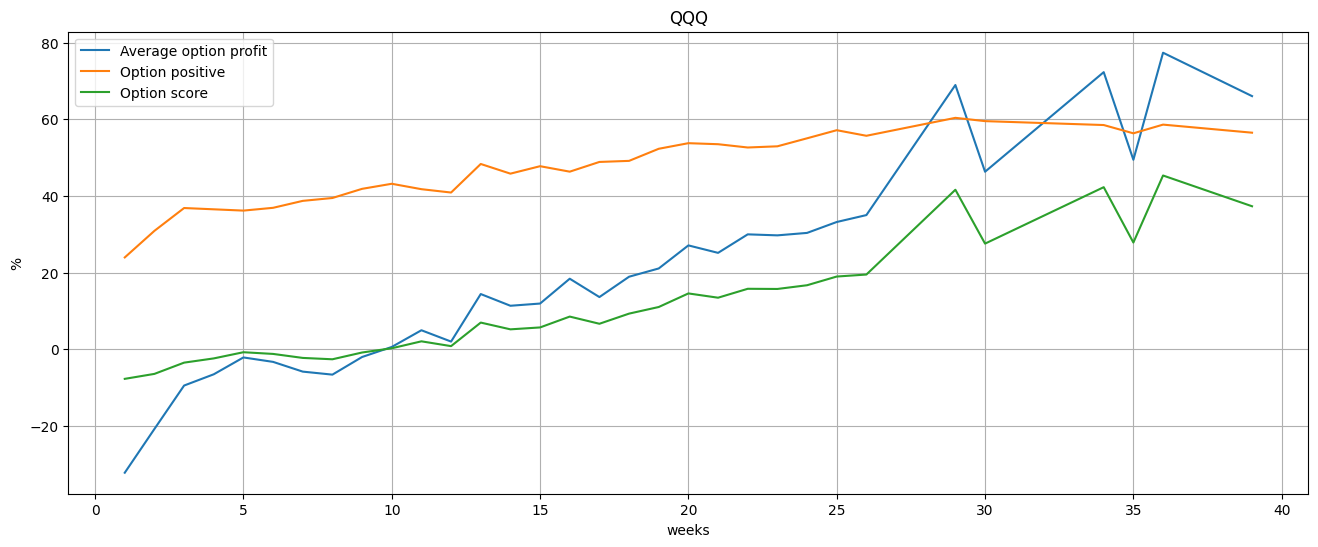

In [20]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit')
plt.plot(option_weeks, option_positive, label='Option positive')
plt.plot(option_weeks, option_score, label='Option score')
plt.legend(loc='upper left')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

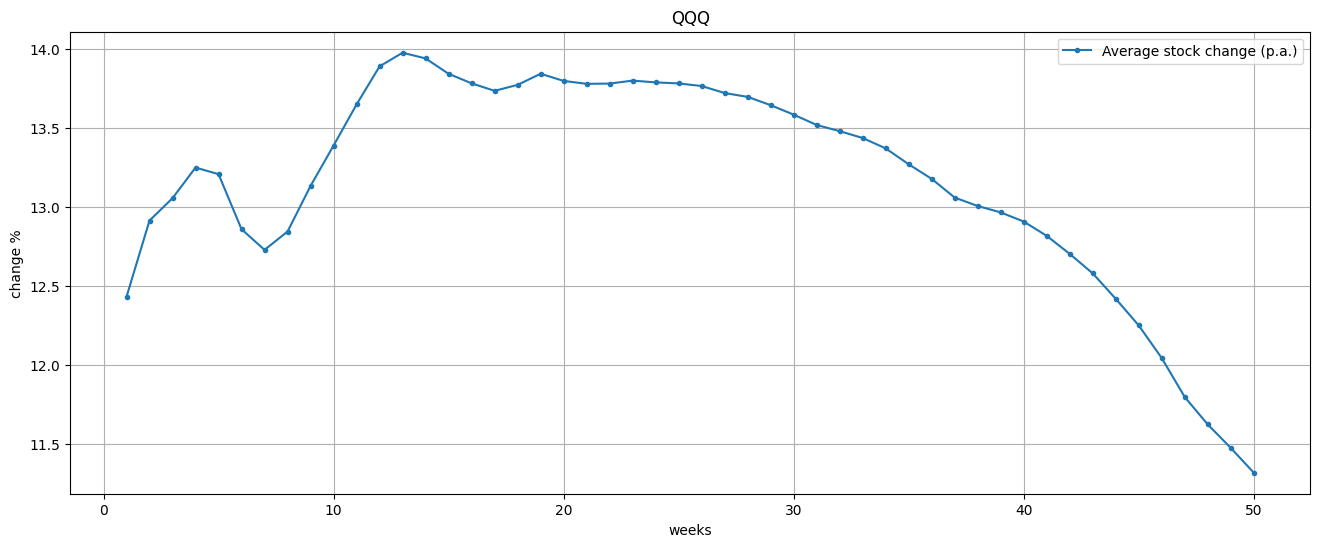

In [21]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Average stock change (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


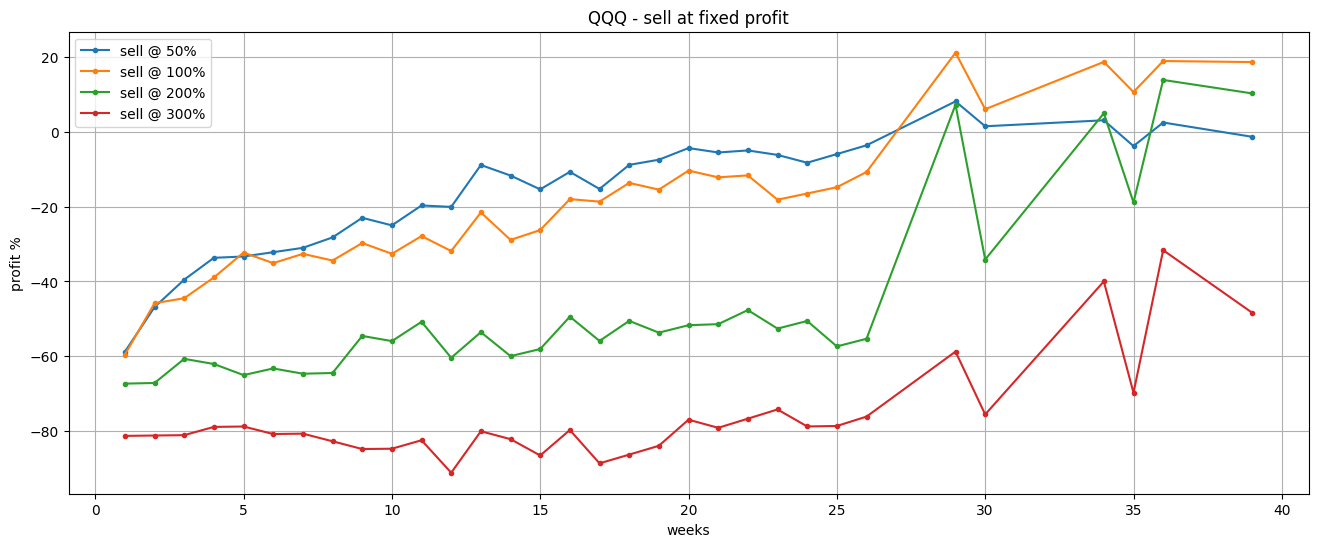

In [22]:
plt.figure(figsize=(16,6))

for percent in [50,100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

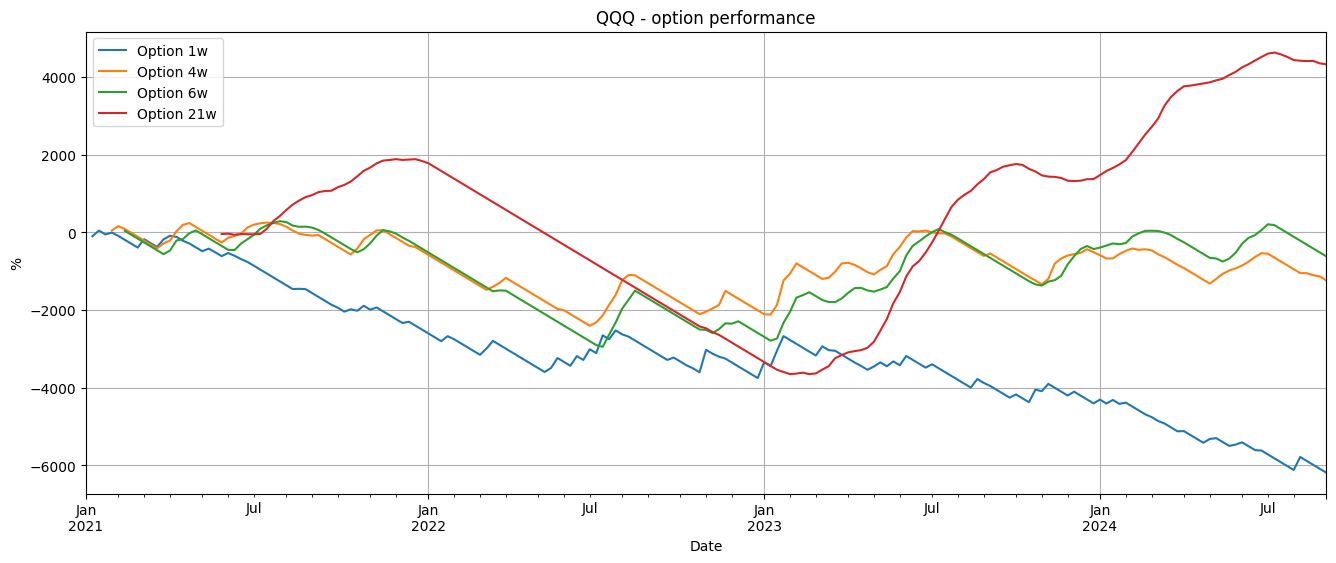

In [24]:
plt.figure(figsize=(16,6))

for w in [1,4,6,21]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend(loc='upper left')
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
# plt.yscale('log')
plt.grid()
plt.show()
